In [1]:
from orangecontrib.bio.ontology import OBOOntology
import networkx as nx
%matplotlib inline
from pylab import * 
from itertools import repeat

## Understand the cell type hierarchy

In order to create cell-specific cell signatures we have to understand where to set 
the 'cut-off' in the cell-hierarchy provided by the ontology. 

Here I will investigate if the ontology provides information that is fine-grained enough for our purposes. 

In [2]:
obo = OBOOntology()
obo.load(open("data/ff-phase2-140729.obo"))

In [3]:
obo.root_terms()

[OBOObject(id='BFO:0000040', name=material entity, ...),
 OBOObject(id='DOID:4', name=disease, ...),
 OBOObject(id='EFO:0000001', name=experimental factor, ...),
 OBOObject(id='FF:0000001', name=sample, ...),
 OBOObject(id='GO:0005575', name=cellular_component, ...),
 OBOObject(id='NCBITaxon:1', name=root, ...),
 OBOObject(id='UBERON:0001062', name=anatomical entity, ...)]

In [4]:
obo.child_terms("FF:0000001")

{OBOObject(id='FF:0000102', name=sample by type, ...),
 OBOObject(id='FF:0000101', name=sample by species, ...),
 OBOObject(id='FF:0000350', name=experimentally modified sample, ...)}

In [5]:
obo.child_terms("FF:0000102")

{OBOObject(id='FF:0000004', name=tissue sample, ...),
 OBOObject(id='FF:0000003', name=cell line sample, ...),
 OBOObject(id='FF:0000002', name=in vivo cell sample, ...)}

Essentially, I want to build a sub-tree of the DAG, starting at 'sample'

## Experiments with networkX
NetworkX looks like a promising library to manipulate graphs created from the Ontology 

In [6]:
G1 = obo.to_networkx(terms=["FF:0000002"])

In [7]:
def tag2name(name):
    return name + ": " + obo.term(name).name
def relable_nodes(graph):
    return nx.relabel_nodes(graph, dict([(name, tag2name(name)) for name in graph.nodes()]))

In [8]:
G1_ = relable_nodes(G1)

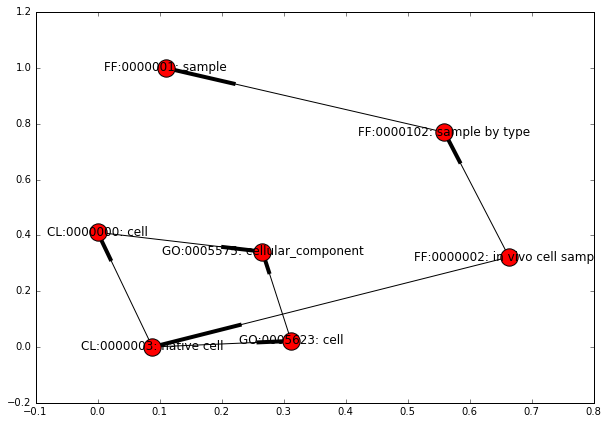

In [42]:
fig, ax = subplots(figsize=(10, 7))
nx.draw_networkx(G1_)

{'CL:0000000': <matplotlib.text.Text at 0x7ff3dba75048>,
 'CL:0000003': <matplotlib.text.Text at 0x7ff3dba75ac8>,
 'FF:0000001': <matplotlib.text.Text at 0x7ff3dba75588>,
 'FF:0000002': <matplotlib.text.Text at 0x7ff3dba6e588>,
 'FF:0000102': <matplotlib.text.Text at 0x7ff3dba6eac8>,
 'GO:0005575': <matplotlib.text.Text at 0x7ff3dba77e80>,
 'GO:0005623': <matplotlib.text.Text at 0x7ff3dba6e048>}

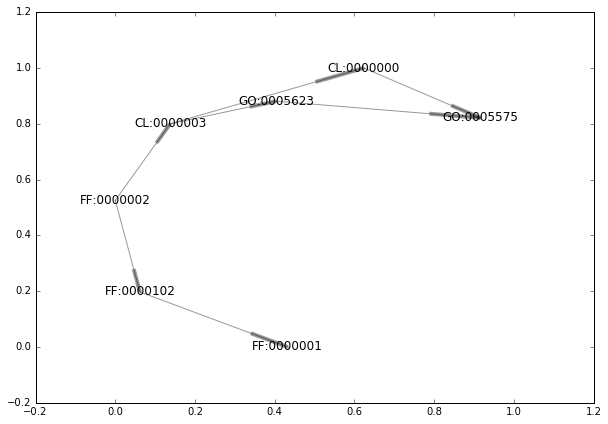

In [41]:
fig, ax = subplots(figsize=(10, 7))
pos = nx.spring_layout(G1)
nx.draw_networkx_nodes(G1,pos,node_size=.5,node_color='w',alpha=0.4)
nx.draw_networkx_edges(G1,pos,alpha=0.4,node_size=0,width=1,edge_color='k')
nx.draw_networkx_labels(G1,pos,fontsize=14)

#### Export to cytoscape
The plotting library is too slow for large graphs and one looses the overview anyway. Fortunately, we can export to `graphml` which can be opened in cytoscape

In [11]:
nx.write_graphml(G1_, "./ontology_network/test.graphml")

## Create Network from all samples
Let's first inspect the Network constructed by OBOOntology from the supergraphs of all samples in the fantom5 dataset:

In [12]:
import pandas as pd

In [43]:
col_vars = pd.read_csv("./data/column_vars.processed.csv")
sample_ids = list(col_vars["obo_id"])

In [15]:
G2 = obo.to_networkx(terms=sample_ids)

In [16]:
nx.write_graphml(G2, "./ontology_network/whole_ontology.graphml")

The resulting network (inspected in cytoscape) is huge, contains circles and contains a vast amount of unneccessary elements. 
Basically it contains the whole Ontology. We need a more fine-grained solution: 

## Building the graph by hand

In [17]:
obo.child_terms("FF:0000102")

{OBOObject(id='FF:0000004', name=tissue sample, ...),
 OBOObject(id='FF:0000003', name=cell line sample, ...),
 OBOObject(id='FF:0000002', name=in vivo cell sample, ...)}

In [19]:
def build_tree(term, graph=nx.Graph(), maxdepth=None): 
    """
    recursively build tree starting with 'term'
    """
    if maxdepth is not None:
        maxdepth -= 1
        if maxdepth <= 0:
            return graph
    for child in obo.child_terms(term):
        graph.add_edge(term, child.id)
        build_tree(child.id, graph, maxdepth)
    return graph 

In [39]:
def build_and_export_tree(term, filename, maxdepth=None):
    graph = build_tree(term, nx.Graph(), maxdepth)
    graph_ = relable_nodes(graph)
    print("The graph has {} nodes".format(len(graph_.nodes())))
    nx.write_graphml(graph_, filename)

#### Structure starting from 'sample'

In [40]:
build_and_export_tree("FF:0000001", "./ontology_network/all_samples.graphml")
build_and_export_tree("FF:0000001", "./ontology_network/all_samples.depth4.graphml", 4)
build_and_export_tree("FF:0000001", "./ontology_network/all_samples.depth3.graphml", 3)

The graph has 4023 nodes
The graph has 2341 nodes
The graph has 307 nodes


We can observe three major categories: "experimentally modified", "by species" and "by type". 
For the cell signatures we are potentially interested in 'by species'->'human' and in the three subcategories of 'by type':
* cell line sample
* in vivo cell sample
* tissue sample

#### Structure starting from human sample

In [46]:
build_and_export_tree("FF:0000210", "./ontology_network/human_samples.graphml")


The graph has 2298 nodes


The resulting graph looks pretty confusing, too. This is due to the fact, that the root node has many direct immediate children. Deleting the root node reveals a bit more of the structure by splitting up the network. However it doesn't provide the hierarchy we would like to have. 

#### Sturcture starting from 'cell line sample'

In [48]:
build_and_export_tree("FF:0000003", "./ontology_network/cell_line_samples.graphml")
build_and_export_tree("FF:0000003", "./ontology_network/cell_line_samples.depth3.graphml", 3)

The graph has 1321 nodes
The graph has 208 nodes


That might be something we could work with... 
Probably I have to filter the results for 'is_a' 'human_sample' 